# Problem: Bike rental forecast
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)


### Approach
- 1. Feature engineer the variables to be fit for the model 
- 2. Split train and test data set for validation 
- 3. Train a LinReg model 
- 3.1 Calculate test score and cross validate
- 4. Train and test Random Forest model
- 4.1 Calculate test score and cross validate
- 5. Optimize Hyperparameters

In [59]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from statsmodels.regression.linear_model import OLS
from scipy.stats import probplot
from scipy.stats import jarque_bera

%matplotlib inline

In [2]:
bike = pd.read_csv('/Users/sabrinafruhauf/Desktop/05_SpicedCourse/Week_03_regression/bike-sharing-demand/train.csv', parse_dates=True)
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 1. Feature engineering

In [3]:
bike["date"] = bike.datetime.apply(lambda x : x.split()[0])
bike["year_num"] = bike.date.apply(lambda x : x.split('-')[0]).astype('int')
bike["month_num"] = bike.date.apply(lambda x : x.split('-')[1]).astype('int')
bike["day_num"] = bike.date.apply(lambda x : x.split('-')[2]).astype('int')
bike["month"] = bike.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
bike["weekday"] = bike.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
bike["hour"] = bike.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype('int')
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year_num,month_num,day_num,month,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,1,1,January,Saturday,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,1,1,January,Saturday,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,1,1,January,Saturday,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,1,1,January,Saturday,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,1,1,January,Saturday,4


In [4]:
bike.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
year_num      0
month_num     0
day_num       0
month         0
weekday       0
hour          0
dtype: int64

In [5]:
bike.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
date           object
year_num        int64
month_num       int64
day_num         int64
month          object
weekday        object
hour            int64
dtype: object

In [6]:
# add a ratio for registered users
bike['reg_ratio'] = bike['registered']/bike['count']

In [7]:
#onehot encoding columns month and weekday
onehot_month = pd.get_dummies(bike['month'])
onehot_weekday = pd.get_dummies(bike['weekday'])

bike = pd.concat([bike, onehot_month, onehot_weekday], axis=1)

In [8]:
# min/max scale temp and atemp
scaler = MinMaxScaler() # scales each column to a min of 0 and a max of 1.0
temp_x = bike['temp'].values.reshape(-1,1)
scaler.fit(temp_x)  # <-- scaler records the minimum and maximum

atemp_x = bike['atemp'].values.reshape(-1,1)
scaler.fit(atemp_x)
bike['temp_scaled'] = scaler.transform(temp_x)
bike['atemp_scaled'] = scaler.transform(atemp_x)

#bike.head()

In [20]:
# add column for intercept (used in stats model later)
bike['intercept'] = 1

In [9]:
#bike.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date', 'year_num', 'month_num', 'day_num', 'month', 'weekday', 'hour',
       'reg_ratio', 'April', 'August', 'December', 'February', 'January',
       'July', 'June', 'March', 'May', 'November', 'October', 'September',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'temp_scaled', 'atemp_scaled'],
      dtype='object')

In [21]:
# reorder columns
bike = bike[['datetime','date', 'year_num', 'month_num', 'day_num', 'month', 'weekday', 'hour', 'season', 
             'holiday', 'workingday', 'weather', 'temp','temp_scaled','atemp', 'atemp_scaled', 'humidity', 
             'windspeed', 'casual', 'registered', 'reg_ratio', 'count',
             'January','February','March','April', 'May', 'June', 'July', 'August', 'September', 'October',
             'November', 'December',
             'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','intercept']]
bike.head()

,datetime,date,year_num,month_num,day_num,month,weekday,hour,season,holiday,...,November,December,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,intercept
0,2011-01-01 00:00:00,2011-01-01,2011,1,1,January,Saturday,0,1,0,...,0,0,0,0,0,0,0,1,0,1
1,2011-01-01 01:00:00,2011-01-01,2011,1,1,January,Saturday,1,1,0,...,0,0,0,0,0,0,0,1,0,1
2,2011-01-01 02:00:00,2011-01-01,2011,1,1,January,Saturday,2,1,0,...,0,0,0,0,0,0,0,1,0,1
3,2011-01-01 03:00:00,2011-01-01,2011,1,1,January,Saturday,3,1,0,...,0,0,0,0,0,0,0,1,0,1
4,2011-01-01 04:00:00,2011-01-01,2011,1,1,January,Saturday,4,1,0,...,0,0,0,0,0,0,0,1,0,1


In [30]:
bike.columns

Index(['datetime', 'date', 'year_num', 'month_num', 'day_num', 'month',
       'weekday', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'temp_scaled', 'atemp', 'atemp_scaled', 'humidity', 'windspeed',
       'casual', 'registered', 'reg_ratio', 'count', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'intercept'],
      dtype='object')

In [13]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime      10886 non-null  object 
 1   date          10886 non-null  object 
 2   year_num      10886 non-null  int64  
 3   month_num     10886 non-null  int64  
 4   day_num       10886 non-null  int64  
 5   month         10886 non-null  object 
 6   weekday       10886 non-null  object 
 7   hour          10886 non-null  int64  
 8   season        10886 non-null  int64  
 9   holiday       10886 non-null  int64  
 10  workingday    10886 non-null  int64  
 11  weather       10886 non-null  int64  
 12  temp          10886 non-null  float64
 13  temp_scaled   10886 non-null  float64
 14  atemp         10886 non-null  float64
 15  atemp_scaled  10886 non-null  float64
 16  humidity      10886 non-null  int64  
 17  windspeed     10886 non-null  float64
 18  casual        10886 non-nu

## 2. Split train and test data set for validation 


In [23]:
x = bike[['datetime', 'date', 'year_num', 'month_num', 'day_num', 'month',
       'weekday', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'temp_scaled', 'atemp', 'atemp_scaled', 'humidity', 'windspeed',
       'casual', 'registered', 'reg_ratio', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday','intercept']]
y = bike['count']
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((8708, 41), (2178, 41), (8708,), (2178,))

In [24]:
df_train = pd.concat([ytrain, xtrain], axis=1)
df_test = pd.concat([ytest, xtest], axis=1)

df_train.shape, df_test.shape

((8708, 42), (2178, 42))

## 3. Train a LinReg model 

In [25]:
# define x and y
x_train = df_train[['year_num', 'hour', 'season', 'holiday', 'workingday','temp_scaled', 'atemp_scaled', 
                    'reg_ratio', 'January', 'February','March', 'April', 'May', 'June', 'July', 'August', 
                    'September','October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 
                    'Thursday', 'Friday', 'Saturday', 'Sunday']]
y_train = df_train['count']

# unused x features:
# 'datetime', 'date', 'weekday', 'month', 
#'month_num', 'day_num', 'weather', 'temp', 'atemp','humidity', 'windspeed','casual', 'registered'

In [46]:
#scores = []
m = LinearRegression()
m.fit(x_train,y_train)
m.score(x_train,y_train)
#m.score(xtest,ytest)
df_train['y_pred'] = m.predict(x_train)

In [47]:
# calculating the residuals
df_train['residuals'] = df_train['count'] - df_train['y_pred']
df_train.head()

,count,datetime,date,year_num,month_num,day_num,month,weekday,hour,season,...,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,intercept,y_pred,residuals
2815,35,2011-07-06 05:00:00,2011-07-06,2011,7,6,July,Wednesday,5,3,...,0,0,1,0,0,0,0,1,96.959999,-61.959999
8695,450,2012-08-04 16:00:00,2012-08-04,2012,8,4,August,Saturday,16,3,...,0,0,0,0,0,1,0,1,406.471063,43.528937
8406,276,2012-07-11 15:00:00,2012-07-11,2012,7,11,July,Wednesday,15,3,...,0,0,1,0,0,0,0,1,324.387849,-48.387849
1543,5,2011-04-10 04:00:00,2011-04-10,2011,4,10,April,Sunday,4,2,...,0,0,0,0,0,0,1,1,12.685621,-7.685621
4952,200,2011-11-19 10:00:00,2011-11-19,2011,11,19,November,Saturday,10,4,...,0,0,0,0,0,1,0,1,131.156009,68.843991


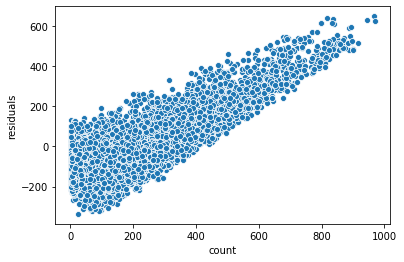

In [55]:
sns.scatterplot(x='count', y='residuals', data=df_train)

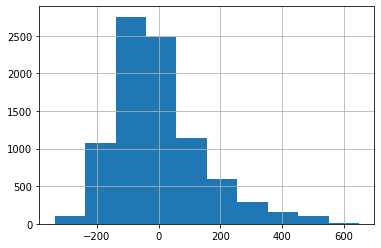

In [56]:
df_train['residuals'].hist()

((array([-3.77627465, -3.5491955 , -3.42443716, ...,  3.42443716,
          3.5491955 ,  3.77627465]),
  array([-335.80557511, -322.50897579, -318.98895996, ...,  635.85035658,
          638.16728106,  648.3348921 ])),
 (139.8281451109788, 5.8094588901005276e-11, 0.9656415956820252))

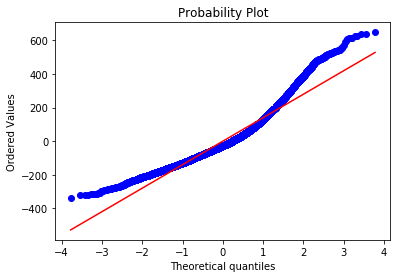

In [58]:
probplot(df_train['residuals'], plot=plt)

In [60]:
jarque_bera(df_train['residuals'])

(2778.632990503042, 0.0)

In [64]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(df_train['residuals'], df_train[['year_num', 'hour', 'season', 'holiday', 'workingday','temp_scaled', 'atemp_scaled', 
                    'reg_ratio', 'January', 'February','March', 'April', 'May', 'June', 'July', 'August', 
                    'September','October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 
                    'Thursday', 'Friday', 'Saturday', 'Sunday']])

(972.9493242166592,
 2.0042345670159345e-188,
 47.491844398470384,
 5.269161969936538e-203)

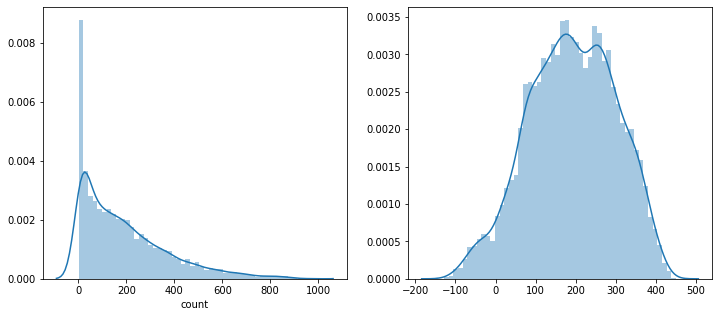

In [66]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(y_pred,ax=ax2,bins=50)

In [73]:
#Mean squared error regression loss

from sklearn.metrics import mean_squared_error
print("MSE Value For Linear Regression: ",mean_squared_error(y_train, y_pred, squared=True).round(3))
print("Root-MSE Value For Linear Regression: ", mean_squared_error(y_train, y_pred, squared=False).round(3))

MSE Value For Linear Regression:  20951.02
Root-MSE Value For Linear Regression:  144.745


In [82]:
#MAE output is non-negative floating point. The best value is 0.0.

from sklearn.metrics import mean_absolute_error
print("Mean absolute error For Linear Regression: ",mean_absolute_error(y_train, y_pred).round(3))

Mean absolute error For Linear Regression:  109.149


In [83]:
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

from sklearn.metrics import r2_score
print("R2 For Linear Regression: ",r2_score(y_train, y_pred).round(3))

R2 For Linear Regression:  0.36


In [28]:
# using statsmodel looking at the features
m_sm = OLS(y_train, df_train[['year_num', 'hour', 'season', 'holiday', 'workingday','temp_scaled', 'atemp_scaled', 
                    'reg_ratio', 'January', 'February','March', 'April', 'May', 'June', 'July', 'August', 
                    'September','October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 
                    'Thursday', 'Friday', 'Saturday', 'Sunday', 'intercept']])
result_sm = m_sm.fit()
result_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     212.8
Date:                Wed, 03 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:37:38   Log-Likelihood:                -55678.
No. Observations:                8708   AIC:                         1.114e+05
Df Residuals:                    8684   BIC:                         1.116e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
year_num        82.8316      3.167     26.153      0.000      76.623      89.040
hour             8.6249      0.236     36.489      0.000       8.162       9.088
season       -1.475e+04    563.449    -26.186      0.000   -1.59e+04   -1.36e+04
holiday      -1.969e+04    751.461    -26.203      0.000   -2.12e+04   -1.82e+04
workingday   -1.968e+04    751.309    -26.191      0.000   -2.12e+04   -1.82e+04
temp_scaled    560.5140     57.443      9.758      0.000     447.913     673.115
atemp_scaled   -25.7678     48.941     -0.527      0.599    -121.704      70.169
reg_ratio       19.5228     14.350      1.361      0.174      -8.606      47.652
January      -2.998e+04   1146.415    -26.155      0.000   -3.22e+04   -2.77e+04
February     -2.999e+04   1146.326    -26.159      0.000   -3.22e+04   -2.77e+04
March            -3e+04   1146.083    -26.173      0.000   -3.22e+04   -2.77e+04
April        -1.524e+04    582.494    -26.162      0.000   -1.64e+04   -1.41e+04
May          -1.525e+04    582.215    -26.190      0.000   -1.64e+04   -1.41e+04
June         -1.528e+04    581.854    -26.259      0.000   -1.64e+04   -1.41e+04
July          -574.7026     19.317    -29.751      0.000    -612.568    -536.837
August        -567.1511     19.239    -29.480      0.000    -604.864    -529.439
September     -521.9334     19.289    -27.058      0.000    -559.745    -484.122
October       1.429e+04    544.663     26.233      0.000    1.32e+04    1.54e+04
November      1.432e+04    544.292     26.318      0.000    1.33e+04    1.54e+04
December      1.432e+04    544.297     26.311      0.000    1.33e+04    1.54e+04
Monday       -7876.1658    300.638    -26.198      0.000   -8465.487   -7286.845
Tuesday      -7880.4743    300.508    -26.224      0.000   -8469.540   -7291.408
Wednesday    -7881.0079    300.599    -26.218      0.000   -8470.252   -7291.763
Thursday     -7867.8479    300.556    -26.178      0.000   -8457.009   -7278.687
Friday       -7862.3351    300.554    -26.159      0.000   -8451.492   -7273.178
Saturday     -2.754e+04   1052.053    -26.174      0.000   -2.96e+04   -2.55e+04
Sunday       -2.756e+04   1052.123    -26.193      0.000   -2.96e+04   -2.55e+04
intercept    -9.446e+04   3606.891    -26.190      0.000   -1.02e+05   -8.74e+04
==============================================================================
Omnibus:                     1538.884   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2778.633
Skew:                           1.120   Prob(JB):                         0.00
Kurtosis:                       4.624   Cond. No.                     1.00e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specif

In [33]:
pair = bike[['count', 'datetime', 'date', 'year_num', 'month_num', 'day_num', 'month',
       'weekday', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'temp_scaled', 'atemp', 'atemp_scaled', 'humidity', 'windspeed',
       'casual', 'registered', 'reg_ratio']]
#unused 
#'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
#'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','intercept'

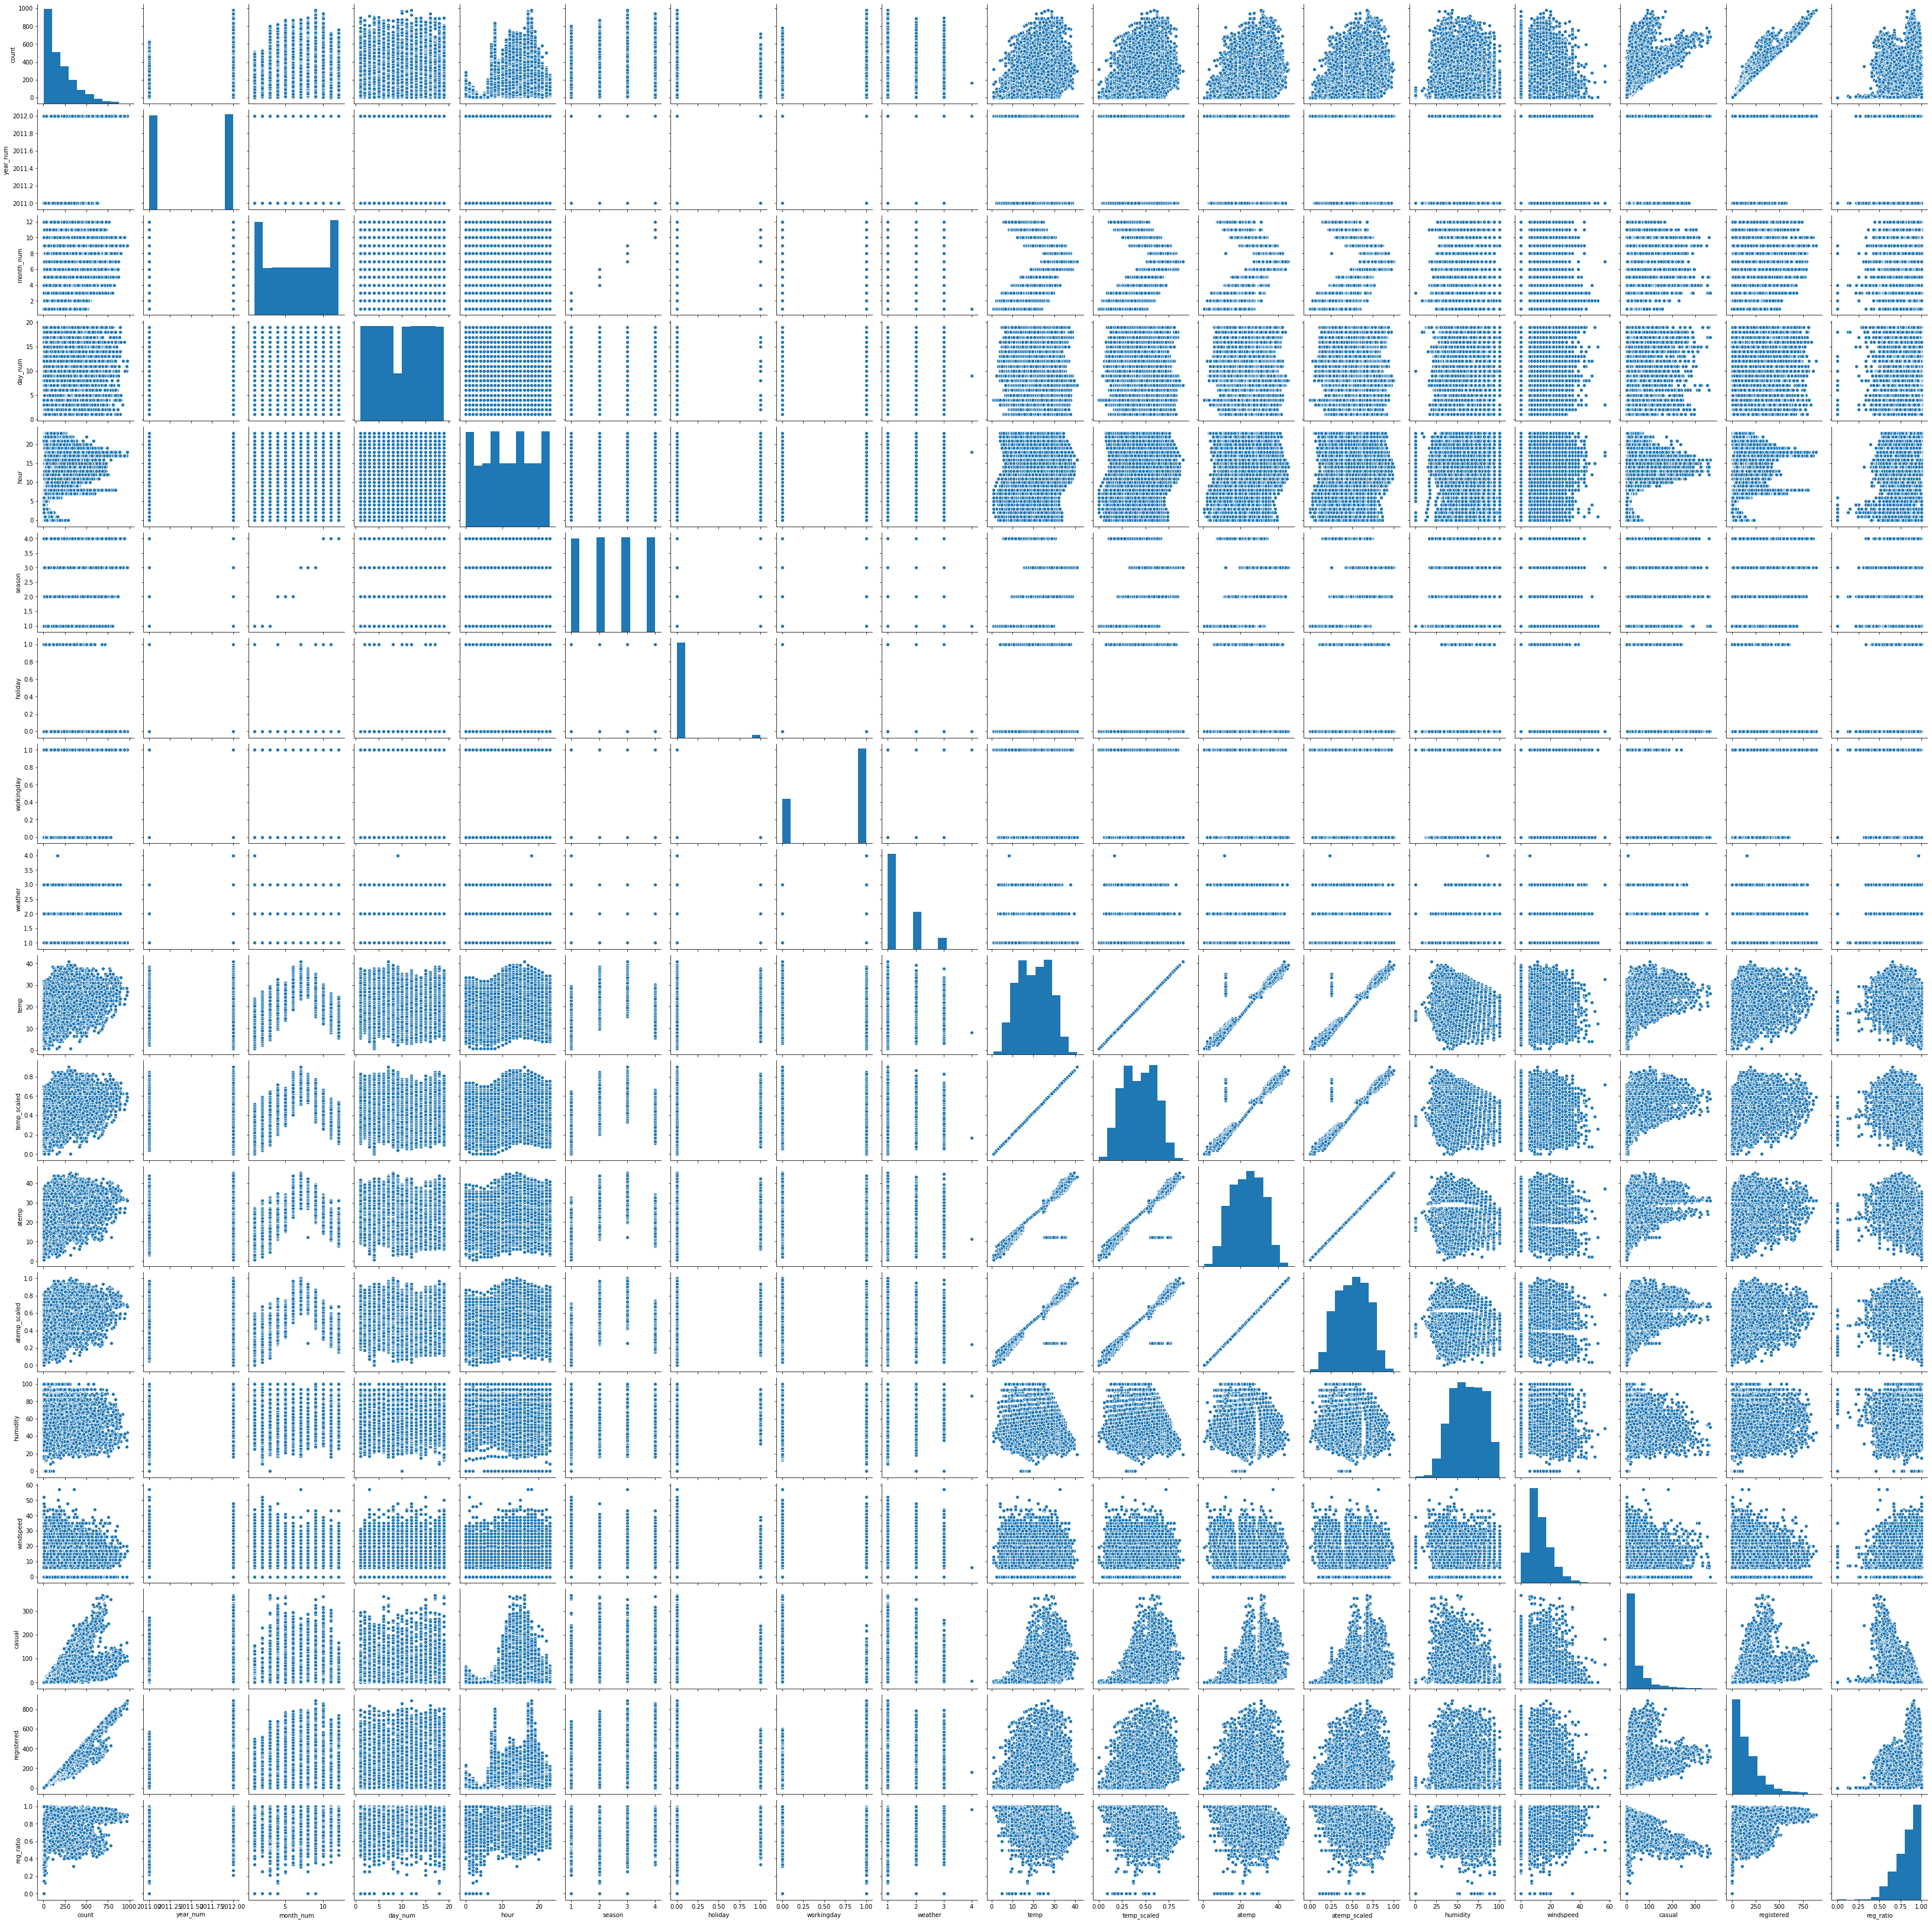

In [34]:
sns.pairplot(pair)

In [35]:
bike.corr()["count"].abs().sort_values(ascending=False)

count           1.000000
registered      0.970948
casual          0.690414
hour            0.400601
temp            0.394454
temp_scaled     0.394454
atemp           0.389784
atemp_scaled    0.389784
humidity        0.317371
year_num        0.260403
month_num       0.166862
January         0.166108
season          0.163439
February        0.135275
reg_ratio       0.131495
weather         0.128655
windspeed       0.101369
June            0.084233
July            0.073038
March           0.071981
August          0.071023
September       0.070374
October         0.060271
May             0.046551
December        0.026644
Sunday          0.024409
day_num         0.019826
Friday          0.013993
Thursday        0.012886
April           0.012354
Saturday        0.011599
workingday      0.011594
Wednesday       0.007117
holiday         0.005393
Tuesday         0.004145
November        0.003509
Monday          0.002663
intercept            NaN
Name: count, dtype: float64

In [37]:
bike.nunique()

datetime        10886
date              456
year_num            2
month_num          12
day_num            19
month              12
weekday             7
hour               24
season              4
holiday             2
workingday          2
weather             4
temp               49
temp_scaled        49
atemp              60
atemp_scaled       60
humidity           89
windspeed          28
casual            309
registered        731
reg_ratio        5247
count             822
January             2
February            2
March               2
April               2
May                 2
June                2
July                2
August              2
September           2
October             2
November            2
December            2
Monday              2
Tuesday             2
Wednesday           2
Thursday            2
Friday              2
Saturday            2
Sunday              2
intercept           1
dtype: int64

In [43]:
def rmsle(y_train, y_pred,convertExp=True):
    if convertExp:
        y_train = np.exp(y_train),
        y_pred = np.exp(y_pred)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y_train]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_pred]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [44]:
from sklearn.metrics import mean_squared_log_error
#y_train_log = np.log1p(y_train)
#rmsle = np.sqrt(mean_squared_log_error( y_train, y_pred))
#print ("RMSLE Value For Linear Regression: ",rmsle)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(y_train),np.exp(y_pred),False))

RMSLE Value For Linear Regression:  inf


/Users/sabrinafruhauf/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sabrinafruhauf/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
